In [16]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
import pandas as pd
from scipy.stats import gaussian_kde
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np

In [17]:
data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"

In [18]:
num_train = 100 # number of training data
deg = 1.0 # polynomial degree
e = 0.5 # scale of normal std or the range of uniform. For the error term
x_dist = 'uniform'
coef_seed = 1
iteration_all = np.arange(0,100)
mu_all = np.round(np.arange(0.1,1.0,0.1),4)
lamb_all = np.round(np.arange(0.0,1.0,0.1),4)

In [19]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
grandparent_directory = os.path.dirname(parent_directory)

In [20]:
def obtain_DDR_avg(iteration_all,mu_all,lamb_all,cost_DDR_all):
    cost_DDR_avg_all = {}
    for iter in iteration_all:
        cost_DDR_avg = np.zeros((len(mu_all),len(lamb_all)))
        mu_index = 0
        for mu in mu_all:
            lamb_index = 0
            for lamb in lamb_all:
                cost_DDR_avg[mu_index,lamb_index] = np.nanmean(cost_DDR_all[iter][mu,lamb])
                lamb_index = lamb_index + 1
            mu_index = mu_index + 1
        cost_DDR_avg_all[iter] = cost_DDR_avg
    return cost_DDR_avg_all

In [21]:
def obtain_ddr_regret(iteration_all,cost_OLS_all,cost_Oracle_para_all,cost_DDR_avg_all):
    regret_ddr_vs_ols_para_all = {}; regret_ddr_vs_ols_para_avg = np.zeros((len(mu_all),len(lamb_all)))

    cost_OLS_avg_all = np.zeros(len(iteration_all))
    cost_Oracle_para_avg_all = np.zeros(len(iteration_all))
    cost_Oracle_realization_avg_all = np.zeros(len(iteration_all))

    for iter_index in range(len(iteration_all)):
        iter = iteration_all[iter_index]
        cost_OLS_avg_all[iter_index] = np.nanmean(cost_OLS_all[iter])
        cost_Oracle_para_avg_all[iter_index] = np.nanmean(cost_Oracle_para_all[iter])
        regret_ddr_vs_ols_para_all[iter_index] = (cost_OLS_avg_all[iter_index] - cost_DDR_avg_all[iter])/np.abs(cost_OLS_avg_all[iter_index] - cost_Oracle_para_avg_all[iter_index])
        
        # regret_ddr_vs_ols_para_all[iter_index] = (cost_OLS_avg_all[iter_index] - cost_DDR_avg_all[iter])/np.abs(cost_OLS_avg_all[iter_index])

        regret_ddr_vs_ols_para_avg = regret_ddr_vs_ols_para_avg + regret_ddr_vs_ols_para_all[iter_index]

    regret_ddr_vs_ols_para_avg = regret_ddr_vs_ols_para_avg/len(iteration_all)
    return regret_ddr_vs_ols_para_avg

In [22]:
def obtain_max_regret(regret_input,mu_all,lamb_all):
    max_regret = -100
    max_mu = 0
    max_lamb = 0
    mu_index = 0
    for mu in mu_all:
        lamb_index = 0
        for lamb in lamb_all:
            if regret_input[mu_index,lamb_index] >= max_regret:
                max_regret = regret_input[mu_index,lamb_index]
                max_mu = mu
                max_lamb = lamb
            lamb_index = lamb_index + 1
        mu_index = mu_index + 1
    print("max_mu=",max_mu,",max_lamb=",max_lamb,",max_regret=",max_regret)
    return max_regret,max_mu,max_lamb

In [24]:
iteration_all = np.arange(100)
num_test = 1000
grid_all = [(2,2),(3,3),(4,4),(5,5)]

In [25]:
regret_opt_all = np.zeros(len(grid_all)); mu_opt_all = np.zeros(len(grid_all)); lamb_opt_all = np.zeros(len(grid_all))

grid_index = 0
for grid in grid_all:
    d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs

    DataPath = os.path.dirname(grandparent_directory) + '/Data/Shortest_Path_Macbook/'+str(grid[0])+'by'+str(grid[1])+'_grid_' + data_generation_process + "_exp=1/"
    DataPath = DataPath + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    print("data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/")
    with open(DataPath+'cost_OLS_all.pkl', 'rb') as f:
        cost_OLS_all = pickle.load(f)
    with open(DataPath+'cost_Oracle_para_all.pkl', 'rb') as f:
        cost_Oracle_para_all = pickle.load(f)
    with open(DataPath+'cost_DDR_all.pkl', 'rb') as f:
        cost_DDR_all = pickle.load(f)

    cost_DDR_avg_all = obtain_DDR_avg(iteration_all,mu_all,lamb_all,cost_DDR_all)
    regret_ddr_vs_ols_para_avg = obtain_ddr_regret(iteration_all,cost_OLS_all,cost_Oracle_para_all,cost_DDR_avg_all)
    regret_opt_all[grid_index],mu_opt_all[grid_index],lamb_opt_all[grid_index] = obtain_max_regret(regret_ddr_vs_ols_para_avg,mu_all,lamb_all)
    grid_index = grid_index + 1


data_size=100_deg=1.0_e=0.5_d=4_x_dist=uniform_num_test=1000_diff_W/
max_mu= 0.5 ,max_lamb= 0.3 ,max_regret= 0.011875242147071075
data_size=100_deg=1.0_e=0.5_d=12_x_dist=uniform_num_test=1000_diff_W/
max_mu= 0.7 ,max_lamb= 0.7 ,max_regret= 0.006746761773233504
data_size=100_deg=1.0_e=0.5_d=24_x_dist=uniform_num_test=1000_diff_W/
max_mu= 0.1 ,max_lamb= 0.2 ,max_regret= 0.001989683098069669
data_size=100_deg=1.0_e=0.5_d=40_x_dist=uniform_num_test=1000_diff_W/
max_mu= 0.3 ,max_lamb= 0.3 ,max_regret= 0.0029551250555248237


In [26]:
print("regret_opt_all=",regret_opt_all)
print("mu_opt_all=",mu_opt_all)
print("lamb_opt_all=",lamb_opt_all)
regret_opt_all_perc = regret_opt_all * 100  # 转为百分数
grid = [2, 3, 4, 5]
file_name = os.path.dirname(grandparent_directory) + '/Data/' + data_generation_process +"Figure_optimal_regret_comparison_among_diff_network.pdf"
print("file_name=",file_name)

regret_opt_all= [0.01187524 0.00674676 0.00198968 0.00295513]
mu_opt_all= [0.5 0.7 0.1 0.3]
lamb_opt_all= [0.3 0.7 0.2 0.3]
file_name= /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/SPO_Data_GenerationFigure_optimal_regret_comparison_among_diff_network.pdf


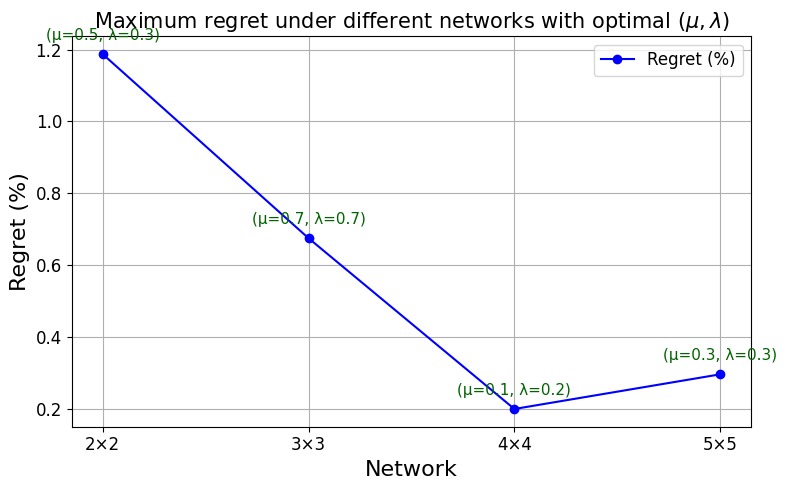

In [ ]:
# 创建图形
plt.figure(figsize=(8, 5))
plt.plot(grid, regret_opt_all_perc, marker='o', linestyle='-', color='blue', label='Regret (%)')

# 添加标注
for i in range(len(grid)):
    label = r"($\mu$={mu_opt_all[i]:.1f}, λ={lamb_opt_all[i]:.1f})"
    plt.annotate(label,
                 (grid[i], regret_opt_all_perc[i]),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 fontsize=11,
                 color='darkgreen')

# 自定义x轴刻度和标签
plt.xticks(ticks=grid, labels=[f"{x}×{x}" for x in grid], fontsize=12)
plt.yticks(fontsize=12)

# 坐标轴标签和标题
plt.xlabel("Network", fontsize=16)
plt.ylabel("Regret (%)", fontsize=16)
plt.title(r"Maximum regret under different networks with optimal $(μ, λ)$", fontsize=15)

plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(file_name, format='pdf')
plt.show()

In [ ]:
grid = (2,2)
num_test = 1000
d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
DataPath = os.path.dirname(grandparent_directory) + '/Data/Shortest_Path_Macbook/'+str(grid[0])+'by'+str(grid[1])+'_grid_' + data_generation_process + "_exp=1/"
DataPath = DataPath + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
print("data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/")
with open(DataPath+'cost_OLS_all.pkl', 'rb') as f:
    cost_OLS_all = pickle.load(f)
with open(DataPath+'cost_Oracle_para_all.pkl', 'rb') as f:
    cost_Oracle_para_all = pickle.load(f)
with open(DataPath+'cost_DDR_all.pkl', 'rb') as f:
    cost_DDR_all = pickle.load(f)

In [11]:
regret_ddr_vs_ols_para_all = {}; regret_ddr_vs_ols_para_avg = np.zeros((len(mu_all),len(lamb_all)))
ratio_ddr_vs_ols_para_all = {}; ratio_ddr_vs_ols_para_avg = np.zeros((len(mu_all),len(lamb_all)))
cost_reduction_ddr_vs_ols_para_all = {}; cost_reduction_ddr_vs_ols_para_avg = np.zeros((len(mu_all),len(lamb_all)))


cost_OLS_avg_all = np.zeros(len(iteration_all))
cost_Oracle_para_avg_all = np.zeros(len(iteration_all))
for iter_index in range(len(iteration_all)):
    iter = iteration_all[iter_index]
    cost_OLS_avg_all[iter_index] = np.nanmean(cost_OLS_all[iter])
    cost_Oracle_para_avg_all[iter_index] = np.nanmean(cost_Oracle_para_all[iter])
    cost_DDR_avg_all = obtain_DDR_avg(iteration_all,mu_all,lamb_all,cost_DDR_all)
    
    regret_ddr_vs_ols_para_all[iter_index] = (cost_OLS_avg_all[iter_index] - cost_DDR_avg_all[iter])/np.abs(cost_OLS_avg_all[iter_index] - cost_Oracle_para_avg_all[iter_index])
    regret_ddr_vs_ols_para_avg = regret_ddr_vs_ols_para_avg + regret_ddr_vs_ols_para_all[iter_index]

    ratio_ddr_vs_ols_para_all[iter_index] = (cost_OLS_avg_all[iter_index] - cost_DDR_avg_all[iter])/np.abs(cost_OLS_avg_all[iter_index])
    ratio_ddr_vs_ols_para_avg = ratio_ddr_vs_ols_para_avg + ratio_ddr_vs_ols_para_all[iter_index]

    cost_reduction_ddr_vs_ols_para_all[iter_index] = (cost_OLS_avg_all[iter_index] - cost_DDR_avg_all[iter])
    cost_reduction_ddr_vs_ols_para_avg = cost_reduction_ddr_vs_ols_para_avg + cost_reduction_ddr_vs_ols_para_all[iter_index]


regret_ddr_vs_ols_para_avg = regret_ddr_vs_ols_para_avg/len(iteration_all)
ratio_ddr_vs_ols_para_avg = ratio_ddr_vs_ols_para_avg/len(iteration_all)
cost_reduction_ddr_vs_ols_para_avg =cost_reduction_ddr_vs_ols_para_avg/len(iteration_all)

In [13]:
pd.DataFrame(regret_ddr_vs_ols_para_avg).to_csv(DataPath+"regret.csv")
pd.DataFrame(ratio_ddr_vs_ols_para_avg).to_csv(DataPath+"ratio.csv")
pd.DataFrame(cost_reduction_ddr_vs_ols_para_avg).to_csv(DataPath+"cost_reduction.csv")

In [12]:
np.round(cost_reduction_ddr_vs_ols_para_avg,4)

array([[ 0.    ,  0.0003,  0.0003,  0.0001, -0.0001, -0.0007, -0.001 ,
        -0.0017, -0.0022, -0.0036],
       [ 0.    , -0.0001, -0.0002, -0.0001, -0.0007, -0.0009, -0.0013,
        -0.0017, -0.0021, -0.0028],
       [ 0.    , -0.    ,  0.0001, -0.    , -0.0003, -0.0004, -0.0005,
        -0.001 , -0.0012, -0.002 ],
       [ 0.    , -0.0001, -0.0002, -0.0004, -0.0005, -0.0005, -0.0006,
        -0.0007, -0.0009, -0.001 ],
       [ 0.    , -0.0001, -0.0001, -0.0001, -0.0002, -0.0002, -0.0003,
        -0.0004, -0.0006, -0.0006],
       [ 0.    , -0.0001, -0.    , -0.0001, -0.    ,  0.    , -0.0002,
        -0.0002, -0.0003, -0.0004],
       [ 0.    , -0.    ,  0.0001,  0.    ,  0.0002,  0.0002, -0.    ,
         0.0001,  0.0001, -0.    ],
       [ 0.    , -0.0001, -0.    ,  0.    ,  0.    , -0.    ,  0.0001,
         0.0002,  0.0002,  0.0002],
       [ 0.    , -0.    , -0.    , -0.0001, -0.    ,  0.    ,  0.    ,
        -0.    , -0.    , -0.0001]])

In [14]:
np.round(ratio_ddr_vs_ols_para_all[iter],4)

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.0001, -0.    ,
        -0.0001, -0.0002, -0.0004],
       [ 0.    ,  0.    , -0.    , -0.    , -0.    , -0.0002, -0.0006,
        -0.001 , -0.0013, -0.0012],
       [ 0.    ,  0.    , -0.    , -0.    , -0.    , -0.    , -0.0004,
        -0.0007, -0.001 , -0.0013],
       [ 0.    ,  0.    , -0.    , -0.0001, -0.0001, -0.0001, -0.0003,
        -0.0003, -0.0003, -0.0004],
       [ 0.    ,  0.    ,  0.    , -0.    , -0.    , -0.0001, -0.0001,
        -0.0001, -0.0002, -0.0002],
       [ 0.    ,  0.    ,  0.    ,  0.    , -0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    , -0.0001, -0.0001, -0.    , -0.0001, -0.0001,
        -0.0001, -0.0002, -0.0002],
       [ 0.    , -0.0001, -0.0001, -0.    , -0.    , -0.    , -0.0001,
        -0.0001, -0.0001, -0.0002],
       [ 0.    ,  0.    , -0.0001, -0.0001, -0.0001, -0.0001, -0.0001,
        -0.0001, -0.0001, -0.0001]])

In [15]:
np.round(regret_ddr_vs_ols_para_all[iter],4)

array([[ 0.    ,  0.    ,  0.    ,  0.0012,  0.0004,  0.0043, -0.0001,
        -0.007 , -0.0102, -0.0277],
       [ 0.    ,  0.    , -0.0002, -0.0002, -0.    , -0.0133, -0.0373,
        -0.0658, -0.0795, -0.0764],
       [ 0.    ,  0.    , -0.0002, -0.0002, -0.    , -0.    , -0.0258,
        -0.0459, -0.0658, -0.081 ],
       [ 0.    ,  0.    , -0.0002, -0.0064, -0.0075, -0.0075, -0.0171,
        -0.0171, -0.0212, -0.026 ],
       [ 0.    ,  0.    ,  0.    , -0.0002, -0.0002, -0.0064, -0.0064,
        -0.0064, -0.012 , -0.0115],
       [ 0.    ,  0.    ,  0.    ,  0.    , -0.0002,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    , -0.0037, -0.0035, -0.0027, -0.0088, -0.0088,
        -0.0072, -0.0138, -0.0138],
       [ 0.    , -0.0037, -0.0035, -0.0027, -0.0027, -0.0027, -0.0082,
        -0.0082, -0.0089, -0.0105],
       [ 0.    ,  0.    , -0.0037, -0.0037, -0.0035, -0.0035, -0.0035,
        -0.0035, -0.0035, -0.0035]])

In [ ]:
regret_ddr_vs_ols_mu_lamb = np.zeros(len(iteration_all))
cost_reduction_ddr_vs_ols_mu_lamb = np.zeros(len(iteration_all))

for iter in iteration_all:
    regret_ddr_vs_ols_mu_lamb[iter] = regret_ddr_vs_ols_para_all[iter][0,4]
    cost_reduction_ddr_vs_ols_mu_lamb[iter] = cost_reduction_ddr_vs_ols_para_all[iter][0,4]


In [ ]:
np.nanmean(regret_ddr_vs_ols_mu_lamb)

In [ ]:
np.quantile(regret_ddr_vs_ols_mu_lamb,0.9)

In [ ]:
np.nanmedian(regret_ddr_vs_ols_mu_lamb)

In [ ]:
np.nanmean(cost_reduction_ddr_vs_ols_mu_lamb)

In [ ]:
np.nanmedian(cost_reduction_ddr_vs_ols_mu_lamb)

In [ ]:
np.quantile(cost_reduction_ddr_vs_ols_mu_lamb,0.9)